In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv
import pydicom 
import nibabel as nb

import os
import glob

### Functions to get a list file paths (.nii, .dcm, .csv etc)

In [ ]:
# Finding File types
def find_dir(start_path, file_type):
    dir_list = []
    for root, _, files in os.walk(start_path): # Crawl through directory to find files
        if any(file.lower().endswith(file_type) for file in files): # Check for files types
            dir_list.append(root)
    return dir_list if dir_list else None  # Return Directory list if there are values inside, else return None

def file_paths(file_type):
    start_directory = '/Users/jasonlee/Desktop/Personal_projects/alzheimers/datasets' # Starting point directory  
    
    file_path_dir = find_dir(start_directory, file_type) # List of paths to directories 
    
    list_files = []
    for paths in file_path_dir: # Looping over list of directories
        for files in glob.glob(os.path.join(paths, f"*{file_type}")): # Looping over all files in directory
            list_files.append(files) 
    return list_files

list_files = file_paths(file_type='.nii')

### Python to PGAdmin functions

In [3]:
# Retrieving PG info
load_dotenv() # Load from .env file

def get_conn():
    # Personal information stored into variables from .env file
    pg_host = os.getenv("PGHOST")
    pg_port = os.getenv("PGPORT")
    pg_user = os.getenv("PGUSER")
    pg_password = os.getenv("PGPASSWORD")
    pg_database = os.getenv("PGDATABASE")

    # Creating PG connection
    return psycopg2.connect(
            database = pg_database,
            user = pg_user,
            password = pg_password,
            host = pg_host,
            port = pg_port
        )

def create_pgdb(db_name):
    conn = get_conn() # Establish connection to pgadmin
    conn.autocommit = True # Run commands outside a transaction

    cursor = conn.cursor() # Allows for SQL code execution

    sql = f''' CREATE database {db_name}''' # SQL query / code

    cursor.execute(sql) # Executes SQL query / code

    conn.close() # Close connection between Python & PG

### CSVs to PGAdmin

In [ ]:
csv_list = file_paths('.csv')

df_list = []
for dfs in csv_list:
    df = pd.read_csv(dfs)
    df_list.append(df)
    
subject_df = df_list[0]
image_df = df_list[1]

# Loading .env file variables
load_dotenv()

# Personal information stored into variables from .env file
pg_host = os.getenv("PGHOST")
pg_port = os.getenv("PGPORT")
pg_user = os.getenv("PGUSER")
pg_password = os.getenv("PGPASSWORD")
pg_database = os.getenv("PGDATABASE")

engine = create_engine(f"postgresql+psycopg2://{pg_user}:{pg_password}@{pg_host}:{pg_port}/alzheimers")

### PET Image slices

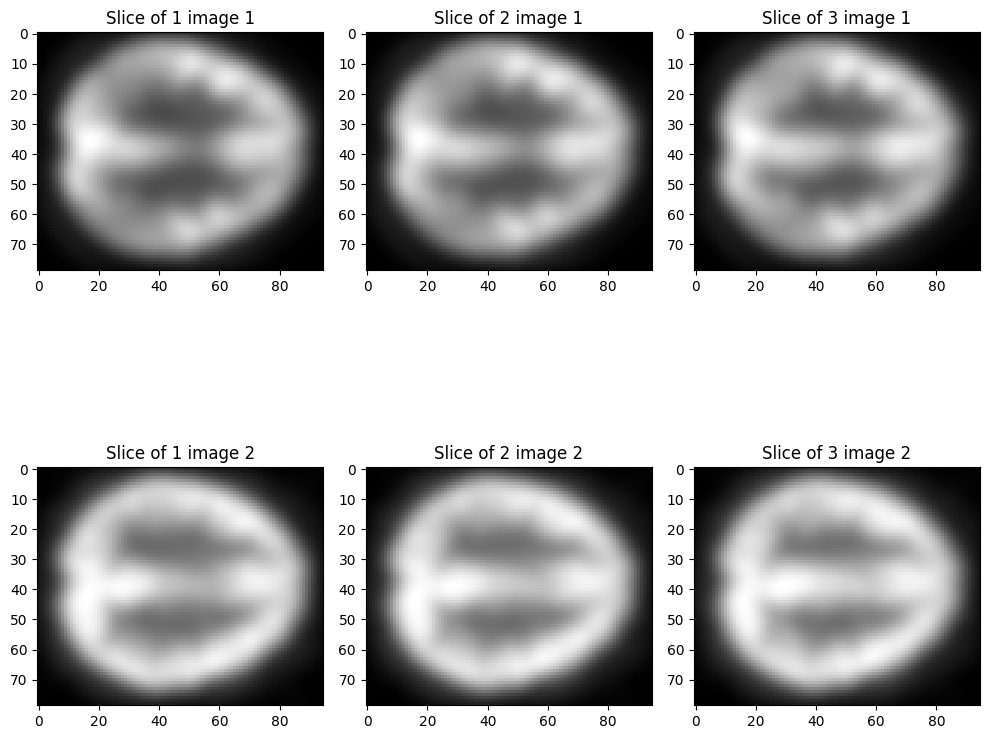

In [5]:
list_files = file_paths(file_type='.nii') # Getting all .nii files

# List of all raw images
img_list = []
for img_path in list_files:
    img = nb.load(img_path) # Load nii images
    img_list.append(img)
    
# List of arrays (converted from images)
array_list = []
for img in img_list:
    img_data = np.array(img.dataobj) # Converting image data to np array
    array_list.append(img_data)
    
n_uimg = len(img_list) # Number of unique images (meaning people)
n_rows = 3 # Number of subplot rows

# Graphing subplot images
fig, ax = plt.subplots(n_uimg, n_rows, figsize = (10,10)) # rows (n_uimg) x columns (n_rows)

for i, img in enumerate(array_list): # Rows loop
    for j in range(3): # Columns loop
        ax[i,j].imshow(img[:,:,40+j], cmap = 'gray') # i = rows, j = column, 40th + j slice, gray color map
        ax[i,j].set_title(f"Slice of {j+1} image {i+1}") 

plt.tight_layout()
plt.show()

##### NII file type
- Format type is x, y, z for height, length, and depth
- There is a 4th dimension, t, for time
- Similar to a deck of cards

##### PET Scan
- Not as accurate as MRI's 
- Different studies have shown different varying results in determining AD vs regular dementia or Parkinsons Disease 
- Scans amyloid plaque build up in the brain

##### PET Image Description
- Description: Tx origin, Spatially Normalized, Smoothed
    - Tx Origin
        - IDK
    - Spatially Normalized
        - Form of reshaping an image to the 'reference' brain space 
    - Smoothed
        - Process of averaging the signal in each voxel with a weighted average of the signal of neighboring voxels
            - Voxel (volume element) is a 3d square or rectangular chunk of brain
        - Gaussian kernel filter - form of convolution

### Turning Nii into Numpy files 

In [ ]:
# Slices to use in CNN
# Posterior cingulate cortex, Precuneus, Parietotemporal cortex, Medial temporal lobes (including hippocampus)
# Mid to upper axial slices
chosen_slices = [25, 30, 35, 40, 45, 50, 55, 60] # 0 - 80

csv_files = file_paths(file_type='.csv') # Getting all .csv files
nii_files = file_paths(file_type='.nii') # Getting all .nii files

# Getting all unique subjects and their AD diagnosis
df = pd.read_csv(csv_files[0], usecols=['subject_id', 'DXAD'])
df['DXAD'] = df['DXAD'].fillna(0)
df = df.drop_duplicates()
df = df.groupby('subject_id')['DXAD'].max().reset_index() # Getting max DXAD for user, 1 for AD 0 for no AD
df['subject_id'] = df['subject_id'].astype(str)
subject_dict = dict(zip(df['subject_id'], df['DXAD'])) # Turn to dictionary from 2 columns

# Getting slices for subjects
for nii in nii_files:
    matches = next((subj for subj in subject_dict if subj in nii), None) # Looping to replace the file path name w/ subject
    
    if matches: # Validation condition 
        nii_img = nb.load(nii) # Loading nii file
        img_data = np.array(nii_img.dataobj) # Turning nii file to arrays
        dxad = subject_dict[matches] # Getting dxad from each subject
    
        # Looping over chosen slices
        for slice in chosen_slices:
            arr = img_data[:,:,slice] # Getting np array slice
            np.save(f'datasets/subject_npy/subject{matches}_slice{slice}_label_{int(dxad)}.npy', arr) # Saving subject and their slice to npy file

### Training CNN Model

In [ ]:
# Preprocess data
transform = transforms.Compose([ #  Chain multiple image transformations 
    transforms.ToPILImage(), # Convert numpy array to PIL image to resize
    transforms.Resize((70,70)), # Resize to have uniform length x height
    transforms.ToTensor(), # Turn images to tensors (nd array objects)
    transforms.Normalize((0.5), (0.5)) # Normalize data between -1 and 1 for faster convergence
])

class PET_Dataset(Dataset): # Inheriting Dataset subclass from Pytorch to ensure it works with DataLoader
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir # Directory with file names
        self.transform = transform # Transform pipeline 
        self.files = file_paths('.npy') # List of all npy files
    
    # Required method in DataLoader class
    def __len__(self):
        return len(self.files) # Number of .npy files
    
    # Required method in DataLoader class
    def __getitem__(self, idx):
        file_path = os.path.join(self.npy_dir, self.files[idx]) # Gets file path for a given index
        
        slice_data = np.load(file_path) # Loads file into np array
        
        label = int(self.files[idx].split('_label_')[1].replace('.npy', '')) # Extracts DXAD label by str split and str replace
        
        # Transformation validation
        if self.transform:
            slice_data = self.transform(slice_data)
            
        return slice_data, label

# CNN Model
class PET_CNN(nn.Module):
    def __init__(self):
    # Determine what the Convolutional architecture looks like with different layers
        super().__init__()
        
        # 1st Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1) # (68x68x5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (34x34x5)
        
        # 2nc Conv layer
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1) # (32x32x10)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # (16x16x10) -> Flatten for Fully Connected Layer
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(16 * 16 * 10, 100) # Multiplying the pixels to flatten
        self.fc2 = nn.Linear(100, 84) # Adding another layer
        self.fc3 = nn.Linear(84, 1) # Output only 1 classes, binary
    
    def forward(self, x):
    # Progresses data across layers
    
        # 1st Conv layer
        x = F.relu(self.conv1(x)) # Relu activation function to break linearity after conv1 layer
        x = self.pool1(x) # Max pooling after relu
        
        # 2nd Conv Layer
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Fully Connected Layer
        x = torch.flatten(x,1) # Turn images to vectors (1d array)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Binary output
        
        return x

# Instantiate data
dataset = PET_Dataset(npy_dir='datasets/subject_npy', transform=transform) # Custom transformed dataset 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Go through Pytorch DataLoader using custom Dataset
model = PET_CNN() # Instantiate CNN model to variable

# Training data
criterion = nn.BCEWithLogitsLoss() # For binary output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20 # 20 iterations
for epoch in range(num_epochs): 
    running_loss = 0.0 # Starting a running_loss variable with 0
    for images, labels in dataloader:
        optimizer.zero_grad() # Zero the gradient of each batch so the prior batch doesn't influence current batch
        
        outputs = model(images) # Returns a tensor of numbers per image, our y prediction (y_pred). Shape = (16 x 1 x 70 x70)
        labels = labels.float().view(-1,1) # Turns label (binary 1 -0) into float then vector column with shape (16 x 1)
        
        loss = criterion(outputs, labels) # BCEWithLogitsLoss formula 
        loss.backward() # Start backpropagation to calculate the gradients of the loss with respect to the parameters (weights & biases)
        
        optimizer.step() # Adam optimizer
        
        running_loss += loss.item() # Calculates total loss by converting tensor into int
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")


# Saving our trained model with parameters
# save_path = 'datasets/trained_model'
# torch.save(model, save_path)

Epoch [1/20], Loss: 0.6929
Epoch [2/20], Loss: 0.6876
Epoch [3/20], Loss: 0.6791
Epoch [4/20], Loss: 0.6688
Epoch [5/20], Loss: 0.6554
Epoch [6/20], Loss: 0.6395
Epoch [7/20], Loss: 0.6203
Epoch [8/20], Loss: 0.5975
Epoch [9/20], Loss: 0.5714
Epoch [10/20], Loss: 0.5419
Epoch [11/20], Loss: 0.5090
Epoch [12/20], Loss: 0.4728
Epoch [13/20], Loss: 0.4337
Epoch [14/20], Loss: 0.3923
Epoch [15/20], Loss: 0.3494
Epoch [16/20], Loss: 0.3051
Epoch [17/20], Loss: 0.2638
Epoch [18/20], Loss: 0.2265
Epoch [19/20], Loss: 0.1907
Epoch [20/20], Loss: 0.1585
